In [1]:
! cat data/neko.txt | cabocha -f3 > data/neko.txt.cabocha

### 40. 係り受け解析結果の読み込み（形態素）

In [2]:
class Morph:
    def __init__(self, token):
        self.surface = token.text
        feature = token.attrib['feature'].split(',')
        self.base = feature[6]
        self.pos = feature[0]
        self.pos1 = feature[1]

In [3]:
import xml.etree.ElementTree as ET

with open("data/neko.txt.cabocha") as f:
    root = ET.fromstring("<sentences>" + f.read() + "</sentences>")

In [4]:
neko = []
for sent in root:
    sent = [chunk for chunk in sent]
    sent = [Morph(token) for chunk in sent for token in chunk]
    neko.append(sent)

In [5]:
for x in neko[2]:
    print(x.surface)

　
吾輩
は
猫
で
ある
。


### 41. 係り受け解析結果の読み込み（文節・係り受け）

In [6]:
class Chunk:
    def __init__(self, chunk):
        self.morphs = [Morph(morph) for morph in chunk]
        self.dst = int(chunk.attrib['link'])
        self.srcs = []

In [7]:
def convert_chunks(sent):
    sent = [Chunk(chunk) for chunk in sent]
    for i, chunk in enumerate(sent):
        if chunk.dst != -1:
            sent[chunk.dst].srcs.append(i)
    return sent

In [8]:
neko = []
for sent in root:
    sent = [chunk for chunk in sent]
    sent = convert_chunks(sent)
    neko.append(sent)

In [9]:
from tabulate import tabulate

In [10]:
table = [
    [''.join([morph.surface for morph in chunk.morphs]), chunk.dst]
    for chunk in neko[7]
]
tabulate(table, tablefmt = 'html', headers = ['番号', '文節', '係り先'], showindex = 'always')

番号,文節,係り先
0,吾輩は,5
1,ここで,2
2,始めて,3
3,人間という,4
4,ものを,5
5,見た。,-1


### 42. 係り元と係り先の文節の表示

In [11]:
import re

In [12]:
def chunk_to_str_without_punctuations(chunk):
    x = ''.join([morph.surface for morph in chunk.morphs])
    x = re.sub(r'[、。]', '', x)
    x = x.strip()
    return x

In [13]:
sent = neko[7]
for chunk in sent:
    if chunk.dst != -1:
        src = chunk_to_str_without_punctuations(chunk)
        dst = chunk_to_str_without_punctuations(sent[chunk.dst])
        print('%s\t%s' % (src, dst))

吾輩は	見た
ここで	始めて
始めて	人間という
人間という	ものを
ものを	見た


### 43. 名詞を含む文節が動詞を含む文節に係るものを抽出

In [14]:
def has_noun(chunk):
    return any(morph.pos == '名詞' for morph in chunk.morphs)

def has_verb(chunk):
    return any(morph.pos == '動詞' for morph in chunk.morphs)

In [15]:
sent = neko[7]
for chunk in sent:
    if chunk.dst != -1 and has_noun(chunk) and has_verb(sent[chunk.dst]):
        src = chunk_to_str_without_punctuations(chunk)
        dst = chunk_to_str_without_punctuations(sent[chunk.dst])
        print('%s %s' % (src, dst))

吾輩は 見た
ここで 始めて
ものを 見た


### 44. 係り受け木の可視化

In [16]:
from pydot import Dot, Edge, Node
from PIL import Image

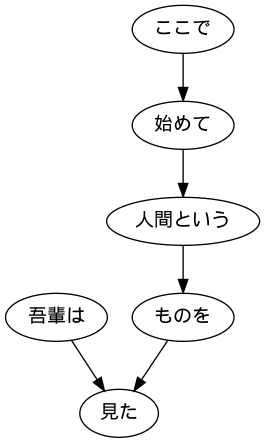

In [17]:
sent = neko[7]

graph = Dot(graph_type = 'digraph')

# 節を作る
for i, chunk in enumerate(sent):
    node = Node(i, label = chunk_to_str_without_punctuations(chunk))
    graph.add_node(node)
    
# 枝を作る
for i, chunk in enumerate(sent):
    if chunk.dst != -1:
        edge = Edge(i, chunk.dst)
        graph.add_edge(edge)
        
graph.write_png('result/sent.png')
Image.open('result/sent.png')

### 45. 動詞の格パターンの抽出

In [18]:
def get_first_verb(chunk):
    for morph in chunk.morphs:
        if morph.pos == '動詞':
            return morph.base

def get_last_case(chunk):
    for morph in chunk.morphs[::-1]:
        if morph.pos == '助詞':
            return morph.surface
        
def extract_cases(srcs):
    xs = [get_last_case(src) for src in srcs]
    xs = [x for x in xs if x]
    xs.sort()
    return xs

In [19]:
with open('result/case_pattern.txt', 'w') as f:
    for sent in neko:
        for chunk in sent:
            if verb := get_first_verb(chunk):
                srcs = [sent[src] for src in chunk.srcs]
                if cases := extract_cases(srcs):
                    line = '{}\t{}'.format(verb, ' '.join(cases))
                    print(line, file=f)

In [20]:
! cat result/case_pattern.txt | sort | uniq -c | sort -nr 2> /dev/null | head -n 10

   2646 ある	が
   1559 つく	か が
    840 云う	は
    553 する	が で と
    380 つかむ	を
    364 思う	と
    334 見る	の
    257 かく	たり を
    253 かかる	が て
    205 ある	まで


In [21]:
! cat result/case_pattern.txt | grep 'する' | sort | uniq -c | sort -nr 2> /dev/null | head -n 10

   1240 する	が
    806 する	て は
    313 する	が で と
    140 する	でも に
    102 する	まで
     84 する	と は は は
     59 する	から が で
     32 する	から て て を
     32 する	を んで
     24 する	として


In [22]:
! cat result/case_pattern.txt | grep '見る' | sort | uniq -c | sort -nr 2> /dev/null | head -n 10

    334 見る	の
    121 見る	は を
     40 見る	て て は
     25 見る	たり て
     23 見る	から
     12 見る	から て て
      8 見る	て に は を
      7 見る	が ので
      3 見る	て ばかり
      3 見る	が て んで


In [23]:
! cat result/case_pattern.txt | grep '与える' | sort | uniq -c | sort -nr 2> /dev/null | head -n 10

      7 与える	に を
      4 与える	で に を
      3 与える	て と は を
      1 与える	けれども は を
      1 与える	か として
      1 与える	が て と に は は を
      1 与える	て に に は を


### 46. 動詞の格フレーム情報の抽出

In [24]:
def extract_args(srcs):
    xs = [src for src in srcs if get_last_case(src)]
    xs.sort(key = lambda src : get_last_case(src))
    xs = [chunk_to_str_without_punctuations(src) for src in xs]
    return xs

In [25]:
for sent in neko[:10]:
    for chunk in sent:
        if verb := get_first_verb(chunk):
            srcs = [sent[src] for src in chunk.srcs]
            if cases := extract_cases(srcs):
                args = extract_args(srcs)
                line = '{}\t{}\t{}'.format(verb, ' '.join(cases), ' '.join(args))
                print(line)

生れる	で	どこで
つく	か が	生れたか 見当が
泣く	で	所で
する	て は	泣いて いた事だけは
始める	で	ここで
見る	は を	吾輩は ものを
聞く	で	あとで
捕える	を	我々を
煮る	て	捕えて
食う	て	煮て


### 47. 機能動詞構文のマイニング

In [26]:
def is_sahen(chunk):
    return len(chunk.morphs) == 2 and chunk.morphs[0].pos1 == 'サ変接続' and chunk.morphs[1].surface == 'を'

def split_sahen(srcs):
    for i in range(len(srcs)):
        if is_sahen(srcs[i]):
            sahen = chunk_to_str_without_punctuations(srcs[i])
            return sahen, srcs[:i] + srcs[i+1:]
    return None, srcs

In [27]:
with open('result/sahen_pattern.txt', 'w') as f:
    for sent in neko:
        for chunk in sent:
            if verb := get_first_verb(chunk):
                srcs = [sent[src] for src in chunk.srcs]
                sahen, rest = split_sahen(srcs)
                if sahen and (cases := extract_cases(rest)):
                    args = extract_args(rest)
                    line = '{}\t{}\t{}'.format(sahen + verb, ' '.join(cases), ' '.join(args))
                    print(line, file=f)

In [28]:
! cat result/sahen_pattern.txt | cut -f 1 | sort | uniq -c | sort -nr 2> /dev/null | head -n 10

     25 返事をする
     19 挨拶をする
     11 話をする
      9 質問をする
      7 真似をする
      7 喧嘩をする
      5 質問をかける
      5 相談をする
      5 昼寝をする
      4 演説をする


In [29]:
! cat result/sahen_pattern.txt | cut -f 1,2 | sort | uniq -c | sort -nr 2> /dev/null | head -n 10

     10 返事をする	と
      7 返事をする	と は
      7 挨拶をする	で
      5 質問をかける	と は
      5 喧嘩をする	で
      4 質問をえる	で
      4 話をする	に
      4 挨拶をする	から
      3 返事をする	から と
      3 談話を聞く	が


### 48. 名詞から根へのパスの抽出 

In [30]:
def trace(n, sent):
    path = []
    while n != -1:
        path.append(n)
        n = sent[n].dst
    return path

In [31]:
sent = neko[7]
heads = [n for n in range(len(sent)) if has_noun(sent[n])]
for head in heads:
    path = trace(head, sent)
    path = ' -> '.join([chunk_to_str_without_punctuations(sent[n]) for n in path])
    print(path)

吾輩は -> 見た
ここで -> 始めて -> 人間という -> ものを -> 見た
人間という -> ものを -> 見た
ものを -> 見た


### 49. 名詞間の係り受けパスの抽出

In [32]:
def extract_path(x, y, sent):
    xs = []
    ys = []
    while x != y:
        if x < y:
            xs.append(x)
            x = sent[x].dst
        else:
            ys.append(y)
            y = sent[y].dst
    return xs, ys, x

def remove_initial_nouns(chunk):
    for i, morph in enumerate(chunk.morphs):
        if morph.pos != '名詞':
            break
    return ''.join([morph.surface for morph in chunk.morphs[i:]]).strip()

def path_to_str(xs, ys, last, sent):
    xs = [sent[x] for x in xs]
    ys = [sent[y] for y in ys]
    last = sent[last]
    if xs and ys:
        xs = ['X' + remove_initial_nouns(xs[0])] + [chunk_to_str_without_punctuations(x) for x in xs[1:]]
        ys = ['Y' + remove_initial_nouns(ys[0])] + [chunk_to_str_without_punctuations(y) for y in ys[1:]]
        last = chunk_to_str_without_punctuations(last)
        return ' -> '.join(xs) + ' | ' + ' -> '.join(ys) + ' | ' + last
    else:
        xs = xs + ys
        xs = ['X' + remove_initial_nouns(xs[0])] + [chunk_to_str_without_punctuations(x) for x in xs[1:]]
        last = 'Y' + remove_initial_nouns(last)
        return ' -> '.join(xs + [last])

In [33]:
sent = neko[7]

heads = [n for n in range(len(sent)) if has_noun(sent[n])]
print('パスの先頭:', heads)

pairs = [(heads[n], second) for n in range(len(heads)) for second in heads[n + 1:]]
print('パスの先頭のペア: ', pairs)

for x, y in pairs:
    x_path, y_path, last = extract_path(x, y, sent)
    path = path_to_str(x_path, y_path, last, sent)
    print(path)

パスの先頭: [0, 1, 3, 4]
パスの先頭のペア:  [(0, 1), (0, 3), (0, 4), (1, 3), (1, 4), (3, 4)]
Xは | Yで -> 始めて -> 人間という -> ものを | 見た
Xは | Yという -> ものを | 見た
Xは | Yを | 見た
Xで -> 始めて -> Yという
Xで -> 始めて -> 人間という -> Yを
Xという -> Yを
